In [29]:
import numpy as np
import pandas as pd
import nltk
import pymorphy2
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tuccc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
! pip install plotly
! pip install pymorphy2

  Using cached https://files.pythonhosted.org/packages/a3/33/fff9675c68b5f6c63ec8c6e6ff57827dda28a1fa5b2c2d727dffff92dd47/pymorphy2-0.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6a/84/ff1ce2071d4c650ec85745766c0047ccc3b5036f1d03559fd46bb38b5eeb/DAWG_Python-0.7.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a2/55/8f8cab2afd404cf578136ef2cc5dfb50baa1761b68c9da1fb1e4eed343c9/docopt-0.6.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/02/51/2465fd4f72328ab50877b54777764d928da8cb15b74e2680fc1bd8cb3173/pymorphy2_dicts-2.4.393442.3710985-py2.py3-none-any.whl
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13709 sha256=1f413391515bdcd49845d8683c7df55cac507f408f02236bcb62ee993b112a5d
  Stored in directory: C:\Users\Tuccc\AppData\Local\pip\Cache\wheels\9b\04\dd\7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built docopt


In [30]:
def getTrain(path):
    df = pd.read_csv(path, sep=';', header=None)
    df = df[[3, 4]]
    df.columns = ['text', 'type']
    return df

In [46]:
df_train_positive = getTrain('Data/positive.csv')

df_train_negative = getTrain('Data/negative.csv')

df = pd.concat([df_train_positive, df_train_negative])
df['type'] = list(map(lambda t: 0 if t == -1 else 1, df['type']))

In [47]:
df.head()

,text,type
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [48]:
def cleanText(texts):
    res = []
    stop_words = stopwords.words('russian')
    morph = pymorphy2.MorphAnalyzer()
    for t in texts:
        t = t.lower()
        t = re.sub(r'(http://)[a-zA-Z0-9_./]+', '', t)
        t = re.sub(r'[,!.\n)(":(:D|:d)*&?#;a-zA-Z/%=@_^#$=0-9]', '', re.sub(r'(rt)*\s*@\s*[a-zA-Z0-9_]*(\s|:)+', '', t))
        t = re.sub(r'((\s-\s)|(-\s)|(\s-))', '', t)
        tokens = word_tokenize(t)
        clean_tokens = [word for word in tokens if word not in stop_words]
        #normalized = list(map(lambda word: morph.parse(word)[0].normal_form, clean_tokens))
        #string = ' '.join([str(elem) for elem in normalized])
        string = ' '.join([str(elem) for elem in clean_tokens])
        res.append(string)
    return res

In [49]:
#Очистить от ненужных слов (латиница, символы)

df['text'] = cleanText(df['text'])
df.head()

,text,type
0,школота поверь самое общество профилирующий пр...,1
1,все-таки немного похож мальчик равно,1
2,идиотка испугалась,1
3,углу сидит погибает голода ещё порции взяли хо...,1
4,значит страшилка блинпосмотрев частиу создастс...,1


In [50]:
text_train, text_test, type_train, type_test = train_test_split(df['text'], df['type'], 
                                                                            test_size=0.3, random_state=42)

In [51]:
cv = CountVectorizer()
cv.fit(df['text'])
X_train = cv.transform(text_train)
X_test = cv.transform(text_test)

In [52]:
logit = LogisticRegression()
logit.fit(X_train, type_train)

C:\Users\Tuccc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
print(logit.score(X_train, type_train), logit.score(X_test, type_test))

0.8972497055730148 0.7213707366533924


In [60]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [61]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
    color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
    color='red', label='test')
    plt.legend();

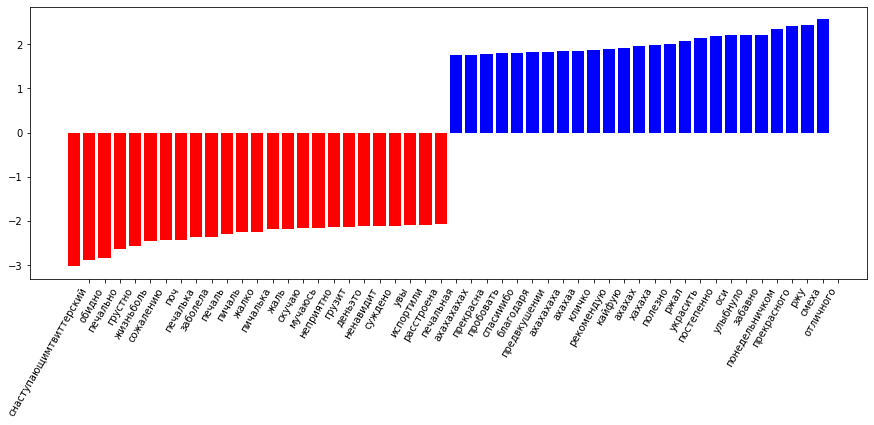

In [62]:
visualize_coefficients(logit, cv.get_feature_names())